# Check on the accuracy of the calculation of the QOCT gradients: case with two perturbation fields

In [1]:
try:
    get_ipython
    isnotebook = True
except:
    isnotebook = False

import os
import sys
import numpy as np
import scipy as sp
import matplotlib
if not isnotebook:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import time
from qutip import *

In [2]:
import qocttools
import qocttools.models.GdW30 as GdW30
import qocttools.hamiltonians as hamiltonians
import qocttools.math_extra as math_extra
import qocttools.pulses as pulses
import qocttools.qoct as qoct
import qocttools.solvers as solvers
import qocttools.target as target

In [3]:
qocttools.about()

Running qocttools version 0.0.1
 (development version; hash 1802d64f9638587dc595c5b21e3bdae611b3a334)


In [4]:
data = []

# Introduction

In order to calculate the optimal pulse that induces a given reaction in a quantum system, one defines a function of that pulse that must be optimized. One important ingredient for the optimization is derivative of this function with respect to the control parameters that define the pulse. In this script we check that this gradient or derivative is calculated correctly.

## Model

The model is defined by the Hamiltonian:

\begin{equation}
        \hat{H}(t) = \hat{H}_0 + f(t)\hat{V}
\end{equation}
where the time-independent part is given by:
\begin{equation}
        \hat{H}_0 = D\bigg[\hat{S}_z^2 - \frac{1}{3}S(S + 1)\bigg] + E[\hat{S}_x^2 - \hat{S}_y^2] - g\mu_B\hat{\vec{S}}\cdot\vec{H}
\end{equation}
and the time-dependent part is:
\begin{equation}
        \hat{H}(t) = \hat{H}_0 + f(t)\hat{V}
\end{equation}
The perturbation is a magnetic field:
\begin{equation}
        \hat{V} = -g\mu_B\hat{\vec{S}}\cdot\vec{H}_m 
\end{equation}

In this case:

* $S = 7/2$

* $D$ = 1281 MHz

* $E$ = 294 MHz

* $\vec{H} = (0.15, 0.0, 0.0)$ T

* $\vec{H}_m = (0, 0.001, 0.0)$ T

In [5]:
S = 7/2 # spin
E = 294 # value in MHz
D = 1281 # value in MHz
dim = int(2*S + 1) #matrix dim

# The target is the population of the first excited state.
target_level = 1

In [6]:
H = np.array([0.15, 0, 0.0], dtype = float) #magnetic field in T
nperts = 2
H_m1 = np.array([0, 0.001, 0], dtype = float) #only in presence of perturbation (T)
H_m2 = np.array([0, 0, 0.001], dtype = float)
H0 = GdW30.hGdW30(D, E, H)
V1 = GdW30.vGdW30(H_m1)
V2 = GdW30.vGdW30(H_m2)

In [7]:
eigenvalues, eigenstates = H0.eigenstates()
H0 = H0.transform(eigenstates) - eigenvalues[0]
V1 = V1.transform(eigenstates)
V2 = V2.transform(eigenstates)

In [8]:
H = hamiltonians.hamiltonian(H0, [V1, V2])

In [9]:
w = np.zeros(dim-1)
taui = np.zeros(dim-1)
for i in range(dim-1):
    w[i] = eigenvalues[i+1] - eigenvalues[i]
    taui[i] = 2.0*np.pi/w[i]
    print("Transition {:d}: w = {:f} MHz, tau = {:f} ns".format(i, w[i], 1000.0*taui[i]/(2.0*np.pi)))

Transition 0: w = 4039.242941 MHz, tau = 0.247571 ns
Transition 1: w = 5393.963412 MHz, tau = 0.185392 ns
Transition 2: w = 5723.217135 MHz, tau = 0.174727 ns
Transition 3: w = 5693.441801 MHz, tau = 0.175641 ns
Transition 4: w = 5184.911330 MHz, tau = 0.192867 ns
Transition 5: w = 4963.368384 MHz, tau = 0.201476 ns
Transition 6: w = 1848.122594 MHz, tau = 0.541090 ns


## Time array definition

In [10]:
T = 5*taui[0]
print("T = {:f} us*2*pi = {:f} ns".format(T, 1000*T/(2.0*np.pi)))
time = math_extra.timegrid(H0, T, 2.0)
print('# Time steps =', time.shape[0])
print('# Delta t =', time[1])

T = 0.007778 us*2*pi = 1.237856 ns
# Time steps = 229
# Delta t = 3.4112618006085835e-05


## Control functions

The control function are parametrized with the Fourier expansion as follow:
\begin{equation}
    f(u, t) = \frac{1}{\sqrt{T}}u_0 + \frac{2}{\sqrt{T}}\sum_{k = 1}^{M}u_{2k}\cos(\omega_kt) + \frac{2}{\sqrt{T}}\sum_{k = 1}^{M}u_{2k + 1}\sin(\omega_kt),
\end{equation}
where $u_0\dots u_{2M + 1}$ are the control parameters. This way, we can compute the derivate respect any control parameter as
\begin{equation}
    \frac{\partial f}{\partial u_m}(u, t) = f(e_m, t),
\end{equation}
where $e_m$ is the set of parameters where all of them are zero except the m-th ane, that is equal to one.

This pulse parametrization is included in the typical_pulses.py file as pulse class.

In [11]:
M1 = 10
M2 = 8

u1 = np.zeros(2*M1+1)
u1[2] = 1.0
u1[3] = 1.0

u2 = np.zeros(2*M2+1)
u2[1] = 1.0

f1 = pulses.pulse("fourier", T, u = u1)
f2 = pulses.pulse("fourier", T, u = u2)

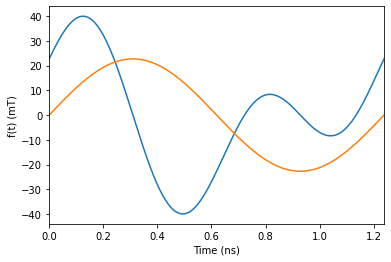

In [12]:
fig, ax = plt.subplots()

ax.plot(time * 1000/(2.0*np.pi), f1.fu(time))
ax.plot(time * 1000/(2.0*np.pi), f2.fu(time))
ax.set_xlabel("Time (ns)")
ax.set_xlim(left = 0.0, right = time[-1]*1000/(2.0*np.pi))
ax.set_ylabel("f(t) (mT)")
if isnotebook:
    plt.show()
else:
    fig.savefig("pulse.pdf")

# Gradient calculation for state-to-state transitions

## QOCT target function definition

In [13]:
lambda_ = 0.1 / sp.integrate.simps(f1.fu(time)*f1.fu(time), time)

def Pfunction(u):
    f1.set_parameters(u[0:f1.nu])
    f2.set_parameters(u[f1.nu:f1.nu+f2.nu])
    return - lambda_ * sp.integrate.simps(f1.fu(time) * f1.fu(time), time) \
           - lambda_ * sp.integrate.simps(f2.fu(time) * f2.fu(time), time)

def dFdu(u, m):
    f1.set_parameters(u[0:f1.nu])
    f2.set_parameters(u[f1.nu:f1.nu+f2.nu])
    if m < f1.nu:
        return - 2.0 * lambda_ * sp.integrate.simps(f1.dfu(time, m) * f1.fu(time), time)
    else:
        return - 2.0 * lambda_ * sp.integrate.simps(f2.dfu(time, m-f1.nu) * f2.fu(time), time)

In [14]:
state_0 = basis(dim, 0) #initial state

In [15]:
u = np.zeros(f1.nu + f2.nu)
u[:f1.nu] = u1[:]
u[f1.nu:] = u2[:]

## Comparison, Schrödinger picture

In [16]:
tg = target.Target('expectationvalue', operator = fock_dm(dim, target_level), Pu = Pfunction, dFdu = dFdu)

opt = qoct.Qoct(H, T, time.shape[0], tg, [f1, f2], state_0,
                interaction_picture = False, solve_method = 'cfmagnus4')

In [17]:
u = np.zeros(f1.nu + f2.nu)
u[:f1.nu] = u1[:]
u[f1.nu:] = u2[:]

In [18]:
derqoct, dernum, error = opt.check_grad(u, 3)
print("QOCT calculation: \t{}".format(derqoct))
print("Ridders calculation: \t{} +- {}".format(dernum, error))

Computed the gradient with the QOCT formula. Elapsed time = 0.14659810066223145 s.
Will compute the 3 component of the gradient.
G(u) = 0.28443741479427953 . Elapsed time = 0.028688430786132812 s.
G(u) = 0.2889333267334892 . Elapsed time = 0.0496058464050293 s.
G(u) = 0.2851591954067333 . Elapsed time = 0.0397334098815918 s.
G(u) = 0.28837000856936773 . Elapsed time = 0.05140852928161621 s.
G(u) = 0.2856584120854724 . Elapsed time = 0.03621482849121094 s.
G(u) = 0.28795164865701395 . Elapsed time = 0.04906201362609863 s.
G(u) = 0.28600668185590733 . Elapsed time = 0.06370687484741211 s.
G(u) = 0.28764463457192413 . Elapsed time = 0.04211735725402832 s.
G(u) = 0.2862512131779237 . Elapsed time = 0.03435158729553223 s.
G(u) = 0.28742115265026524 . Elapsed time = 0.044950246810913086 s.
QOCT calculation: 	-0.22471706476248496
Ridders calculation: 	-0.22471662069997053 +- 3.2790437032304e-13


In [19]:
data.append(derqoct)

In [20]:
derqoct, dernum, error = opt.check_grad(u, f1.nu + 3)
print("QOCT calculation: \t{}".format(derqoct))
print("Ridders calculation: \t{} +- {}".format(dernum, error))

Computed the gradient with the QOCT formula. Elapsed time = 0.13713836669921875 s.
Will compute the 24 component of the gradient.
G(u) = 0.286187082960511 . Elapsed time = 0.04956793785095215 s.
G(u) = 0.287495809307581 . Elapsed time = 0.05634617805480957 s.
G(u) = 0.2863768350981407 . Elapsed time = 0.04223203659057617 s.
G(u) = 0.2873116410576916 . Elapsed time = 0.035477399826049805 s.
G(u) = 0.28651180300779916 . Elapsed time = 0.04160761833190918 s.
G(u) = 0.2871795220699847 . Elapsed time = 0.04023313522338867 s.
G(u) = 0.2866079181163224 . Elapsed time = 0.04086756706237793 s.
G(u) = 0.2870848604929778 . Elapsed time = 0.04585886001586914 s.
G(u) = 0.286676423505893 . Elapsed time = 0.044715166091918945 s.
G(u) = 0.28701709670109377 . Elapsed time = 0.04272317886352539 s.
G(u) = 0.2867252802757111 . Elapsed time = 0.039283037185668945 s.
G(u) = 0.2869686182974347 . Elapsed time = 0.043909311294555664 s.
QOCT calculation: 	-0.06543597218415557
Ridders calculation: 	-0.0654365211

In [21]:
data.append(derqoct)

## Comparison, interaction picture

In [22]:
opt.interaction_picture = True

In [23]:
derqoct, dernum, error = opt.check_grad(u, 3)
print("QOCT calculation: \t{}".format(derqoct))
print("Ridders calculation: \t{} +- {}".format(dernum, error))

Computed the gradient with the QOCT formula. Elapsed time = 0.4973411560058594 s.
Will compute the 3 component of the gradient.
G(u) = 0.28444016087377977 . Elapsed time = 0.18734478950500488 s.
G(u) = 0.2889360683460578 . Elapsed time = 0.18632030487060547 s.
G(u) = 0.28516194120103655 . Elapsed time = 0.19654560089111328 s.
G(u) = 0.2883727511689965 . Elapsed time = 0.19420790672302246 s.
G(u) = 0.28566115760318544 . Elapsed time = 0.2898838520050049 s.
G(u) = 0.28795439189135497 . Elapsed time = 0.21468305587768555 s.
G(u) = 0.28600942713905303 . Elapsed time = 0.18469738960266113 s.
G(u) = 0.2876473782235561 . Elapsed time = 0.180558443069458 s.
G(u) = 0.2862539582747058 . Elapsed time = 0.18750429153442383 s.
G(u) = 0.28742389658148326 . Elapsed time = 0.18318772315979004 s.
G(u) = 0.2864264670380478 . Elapsed time = 0.18630194664001465 s.
G(u) = 0.28726212750700436 . Elapsed time = 0.18463802337646484 s.
QOCT calculation: 	-0.22471688218573868
Ridders calculation: 	-0.22471639677

In [24]:
data.append(derqoct)

In [25]:
derqoct, dernum, error = opt.check_grad(u, f1.nu + 3)
print("QOCT calculation: \t{}".format(derqoct))
print("Ridders calculation: \t{} +- {}".format(dernum, error))

Computed the gradient with the QOCT formula. Elapsed time = 0.7983949184417725 s.
Will compute the 24 component of the gradient.
G(u) = 0.2861898056192208 . Elapsed time = 0.15575122833251953 s.
G(u) = 0.28749857589820327 . Elapsed time = 0.15472745895385742 s.
G(u) = 0.28637956400244613 . Elapsed time = 0.16325020790100098 s.
G(u) = 0.28731440134187314 . Elapsed time = 0.15259909629821777 s.
G(u) = 0.2865145363794317 . Elapsed time = 0.1398630142211914 s.
G(u) = 0.28718227785579853 . Elapsed time = 0.14482927322387695 s.
G(u) = 0.28661065468206476 . Elapsed time = 0.14065003395080566 s.
G(u) = 0.28708761306884384 . Elapsed time = 0.1372373104095459 s.
QOCT calculation: 	-0.06543834730263798
Ridders calculation: 	-0.06543871772998723 +- 5.472566844133553e-13


In [26]:
data.append(derqoct)

# Gradient calculation for state-to-state transitions: parametrization with an auxiliary function

In [27]:
def g(f, j):
    return f[0]

def gradg(f, j, l):
    return 1.0

In [28]:
H = hamiltonians.hamiltonian(H0, [V1, V2], g = g, gradg = gradg)

In [29]:
tg = target.Target('expectationvalue', operator = fock_dm(dim, target_level))

opt = qoct.Qoct(H, T, time.shape[0], tg, [f1], state_0,
                interaction_picture = False,
                solve_method = 'cfmagnus4',
                new_parametrization = True)

In [30]:
u = np.zeros(f1.nu)
u[:f1.nu] = u1[:]
#u[f1.nu:] = u2[:]

In [31]:
derqoct, dernum, error = opt.check_grad(u, 3)
print("QOCT calculation: \t{}".format(derqoct))
print("Ridders calculation: \t{} +- {}".format(dernum, error))

Computed the gradient with the QOCT formula. Elapsed time = 0.09936380386352539 s.
Will compute the 3 component of the gradient.
G(u) = 0.46955366599100434 . Elapsed time = 0.027344942092895508 s.
G(u) = 0.4762117485487156 . Elapsed time = 0.043967485427856445 s.
G(u) = 0.47058776466210694 . Elapsed time = 0.02631092071533203 s.
G(u) = 0.47534329641647854 . Elapsed time = 0.030490875244140625 s.
G(u) = 0.47130943237481904 . Elapsed time = 0.030269622802734375 s.
G(u) = 0.474706152714868 . Elapsed time = 0.036879777908325195 s.
G(u) = 0.47181625779768455 . Elapsed time = 0.028345584869384766 s.
G(u) = 0.47424245451323055 . Elapsed time = 0.03244209289550781 s.
G(u) = 0.4721738653750885 . Elapsed time = 0.03224301338195801 s.
G(u) = 0.4739068513296801 . Elapsed time = 0.03016948699951172 s.
QOCT calculation: 	-0.3328702789946293
Ridders calculation: 	-0.33286960109297153 +- 4.907185768843192e-14


In [32]:
data.append(derqoct)

# Gradient calculation for state-to-state transitions: real-time parametrization of the pulse

In [33]:
u1t = f1.fu(time)
u2t = f2.fu(time)
f1t = pulses.pulse("realtime", T, u = u1t)
f2t = pulses.pulse("realtime", T, u = u2t)

## QOCT target function definition

In [34]:
state_0 = basis(dim, 0) #initial state

In [35]:
ut = np.zeros(f1t.nu + f2t.nu)
ut[:f1t.nu] = u1t[:]
ut[f1t.nu:] = u2t[:]

## Comparison, Schrödinger picture

In [36]:
H = hamiltonians.hamiltonian(H0, [V1, V2])

In [37]:
tg = target.Target('expectationvalue', operator = fock_dm(dim, target_level))

opt = qoct.Qoct(H, T, time.shape[0], tg, [f1t, f2t], state_0,
                interaction_picture = False, solve_method = 'cfmagnus4')

In [38]:
ut = np.zeros(f1t.nu + f2t.nu)
ut[:f1t.nu] = u1t[:]
ut[f2t.nu:f1t.nu+f2t.nu] = u2t[:]

In [39]:
derqoct, dernum, error = opt.check_grad(ut, 3)
print("QOCT calculation: \t{}".format(derqoct))
print("Ridders calculation: \t{} +- {}".format(dernum, error))

Computed the gradient with the QOCT formula. Elapsed time = 0.863286018371582 s.
Will compute the 3 component of the gradient.
G(u) = 0.436869630460187 . Elapsed time = 0.06593203544616699 s.
G(u) = 0.4368746857525621 . Elapsed time = 0.06310534477233887 s.
G(u) = 0.43687035261178236 . Elapsed time = 0.06940078735351562 s.
G(u) = 0.4368739635349098 . Elapsed time = 0.06263113021850586 s.
G(u) = 0.4368708684410908 . Elapsed time = 0.07972192764282227 s.
G(u) = 0.43687344767189745 . Elapsed time = 0.07451343536376953 s.
G(u) = 0.43687123689403656 . Elapsed time = 0.06128859519958496 s.
G(u) = 0.43687307920175544 . Elapsed time = 0.06643152236938477 s.
QOCT calculation: 	-0.0002529916063099046
Ridders calculation: 	-0.0002527646190076763 +- 4.442751505226439e-14


In [40]:
data.append(derqoct)

In [41]:
with open("data", "w") as datafile:
    for i in data:
        datafile.write("{:.14e}\n".format(i))